# Collecting single-cell evidence for a target

1. Select datasets of interest from cell-level metadata (data from disease-relevant tissue, healthy or matched disease)
2. Get single-cell expression data for a target gene (or list of target genes) from cellxgene census 
3. Pseudo-bulk by donor
4. Run DE analysis

In [1]:
pip install obonet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import cellxgene_census
import tiledbsoma as soma
from tiledbsoma.experiment_query import X_as_series
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
# help(cellxgene_census)
# help(cellxgene_census.get_anndata)

In [2]:
import scipy
import anndata

R plotting setup

In [3]:
## r2py setup
# import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# anndata2ri.activate()

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


## Load target and scdatasets data

In [6]:
data_disease = pd.read_csv('./data/association_scores_individual_drugs_data_by_indication.csv', index_col=0)
cxg_metadata = pd.read_csv('/home/jovyan/mount/gdrive/sc_targetID/data/cellxgene_hsapiens_donor_metadata.disease_relevant_annotation.csv', index_col=0)

## Open connection to cellxgene

In [76]:
def _get_cxg_datasets(cxg_metadata, disease_ontology_id, keep_disease_relevant_tissue, keep_normal):
    filt_metadata = cxg_metadata[cxg_metadata['disease_ontology_id'] == disease_ontology_id]
    
    if keep_disease_relevant_tissue:
        filt_metadata = filt_metadata[filt_metadata['tissue_general'] == filt_metadata['disease_relevant_tissue']].copy()

    if keep_normal:
        normal_metadata = cxg_metadata[ (cxg_metadata['disease_ontology_id'] == 'PATO:0000461') & (cxg_metadata['tissue_general'] == filt_metadata['disease_relevant_tissue'].iloc[0]) ]
        filt_metadata = pd.concat([normal_metadata, filt_metadata], axis=0)
    
    return filt_metadata


def get_disease_targets_sc_data(
    disease_ontology_id,
    target_genes, 
    cxg_metadata,
    keep_disease_relevant_tissue = True,
    keep_normal = True
    ):
    '''
    Params:
    -------
    
    - disease_ontology_id: disease of interest (MONDO ID) - downloads data for disease and healthy tissue for disease-relevant tissue
    - target_genes: list of target genes for the disease
    - keep_disease_relevant_tissue: whether to filter only samples from the disease-relevant tissue
    - keep_normal: whether to include data from normal tissue
    
    Returns:
    --------
    adata: AnnData object for targets of interest
    ''' 
    
    OBS_COLS = [
            "assay", 
            "tissue_general", 
            "suspension_type", 
            "disease", 
            'donor_id', 
            'cell_type_ontology_term_id',
            'cell_type'
    ]
    
    # Make string of features 
    target_genes_str = '[' + ', '.join(f"'{item}'" for item in target_genes) + ']'
    
    # Subset to relevant datasets
    sc_metadata = _get_cxg_datasets(cxg_metadata, disease_ontology_id, keep_disease_relevant_tissue, keep_normal)
    dataset_ids = sc_metadata['dataset_id'].unique()
    tissue_ids = sc_metadata['tissue_general_original'].unique()
    disease_ids = sc_metadata['disease_ontology_id_original'].unique()
    tissue_ids_str = '[' + ', '.join(f"'{item}'" for item in tissue_ids) + ']'
    disease_ids_str = '[' + ', '.join(f"'{item}'" for item in disease_ids) + ']'
    dataset_ids_str = '[' + ', '.join(f"'{item}'" for item in dataset_ids) + ']'
    obs_filter_str = f"dataset_id in {dataset_ids_str} and disease_ontology_term_id in {disease_ids_str} and tissue_general in {tissue_ids_str}"
    
    with cellxgene_census.open_soma() as census:
        # Get expression of target genes as anndata
        adata = cellxgene_census.get_anndata(
                census = census,
                organism = "Homo sapiens",
                var_value_filter = f"feature_id in {target_genes_str}",
                obs_value_filter = obs_filter_str,
                column_names = {"obs": OBS_COLS}
            )
        
        # Store total counts per cell (library size for DE analysis) 
        hsapiens = census["census_data"]["homo_sapiens"]
        with hsapiens.axis_query(
            measurement_name="RNA",
            obs_query=soma.AxisQuery(value_filter=obs_filter_str),
        ) as query:
            obs_df = query.obs().concat().to_pandas().set_index("soma_joinid")
            n_obs = len(obs_df)

            raw_sum = np.zeros((n_obs,), dtype=np.float64)  # accumulate the sum of expression

            # query.X() returns an iterator of pyarrow.Table, with X data in COO format.
            # You can request an indexer from the query that will map it to positional indices
            indexer = query.indexer
            for arrow_tbl in query.X("raw").tables():
                obs_dim = indexer.by_obs(arrow_tbl["soma_dim_0"])
                data = arrow_tbl["soma_data"]
                np.add.at(raw_sum, obs_dim, data)

        adata.obs['total_counts'] = raw_sum
        
    return(adata)


In [77]:
target_genes = ['ENSG00000162711']
disease_ontology_id = 'MONDO:0013662' # Barret's esophagus

adata = get_disease_targets_sc_data(target_genes=target_genes, 
                                    disease_ontology_id=disease_ontology_id,
                                    cxg_metadata=cxg_metadata,
                                    keep_disease_relevant_tissue=True,
                                    keep_normal=True
                                   )

The "stable" release is currently 2023-05-15. Specify 'census_version="2023-05-15"' in future calls to open_soma() to ensure data consistency.


In [78]:
adata.var_names = adata.var['feature_id'].values

## Rename cell types to high level

In [82]:
import obonet

obo_file = "data/cl.obo"  # downloaded from http://obofoundry.org/ontology/cl.html

# Load the ontology from the OBO file
graph = obonet.read_obo(obo_file)

def get_ancestors(term_id, graph, levels=3):
    ancestors = set()
    stack = [(term_id, 0)]  # Using a stack to keep track of terms and their levels

    while stack:
        current_term, current_level = stack.pop()
        ancestors.add(current_term)

        if current_level < levels:
            parents = [parent for parent in graph.successors(current_term) if parent.startswith("CL:")]
            stack.extend([(parent, current_level + 1) for parent in parents])

    return ancestors

def get_CL_ancestors(term_id, graph):
    ancestors = get_ancestors(term_id, graph)
    return list(ancestors)

def rename_cts_to_high_level(adata, graph):
    original_terms = adata.obs['cell_type_ontology_term_id'].unique().tolist()
    # Exclude VERY high level annotations (e.g. native cell)
    keep_terms = []
    for o in original_terms:
        if len(get_ancestors(o, graph)) > 5:
            keep_terms.append(o)
    
    new_terms = original_terms.copy()
    for i,term in enumerate(original_terms):
        # Check if cell_type ontology term is the most high level in dataset  
        upstream_CL = get_CL_ancestors(term, graph)
        parent_terms = np.intersect1d(upstream_CL, keep_terms)
        if len(parent_terms) > 0:
            new_terms[i] = parent_terms[0]
    ct_rename_dict = dict(zip(original_terms, new_terms))
    
    # Rename to higher level if it exists
    while any([ct_rename_dict[v] != v for v in ct_rename_dict.values()]):
        for k,v in ct_rename_dict.items():
            if ct_rename_dict[v] != v:
                ct_rename_dict[k] = ct_rename_dict[v]
                
    adata.obs['high_level_cell_type_ontology_term_id'] = [ct_rename_dict[x] for x in adata.obs['cell_type_ontology_term_id']]
    return(ct_rename_dict)

ct_rename_dict = rename_cts_to_high_level(adata, graph)

In [86]:
adata.obs['high_level_cell_type_ontology_term_id'].value_counts()

CL:0000079    51307
CL:0000066    30199
CL:0000034    20642
CL:0002252    20230
CL:0000192    13607
CL:0000115     5463
CL:0000084     4214
CL:0000646     3712
CL:0000584     2681
CL:0000071     2430
CL:0002179     2076
CL:0000145     1805
CL:0000236     1636
CL:0000097     1162
CL:0002573      970
CL:0000183      965
CL:1000447      754
CL:0000651      613
CL:0000234      334
CL:0002088      225
CL:0019031      224
CL:0000003      217
CL:0000163      213
CL:0000492      158
CL:0000623      129
CL:0000232       80
CL:0000319       55
CL:0000775       42
CL:0000540       25
CL:0000155       10
CL:2000095        3
CL:0000162        2
CL:1000909        1
Name: high_level_cell_type_ontology_term_id, dtype: int64

### Pseudo-bulk data

In [87]:
def anndata2pseudobulk(adata, group_by, 
                       agg="s", 
                       min_ncells = 3,
                       use_layer = None
                      ):
    '''
    Do pseudo-bulking of raw counts in anndata object
    
    Params:
    ------
    - adata: the anndata object
    - group_by: list of obs columns to use for aggregation
    - agg: "s" for sum (if adata.X are counts), "m" for mean (if adata.X are log-counts)
    - min_ncells: minimum number of cells to keep pseudobulk sample (default: 10)
    - use_layer: which layer to use for pseudobulking (default: None, use adata.X)
    
    Returns:
    -------
    AnnData object of same n_vars as adata, but pseudobulked obs
    '''    
    if use_layer is None:
        X = adata.X.copy()
    else:
        X = adata.layers[use_layer].copy()
        
    ## Make obs for pseudobulk
    pseudobulk_obs = adata.obs[group_by].drop_duplicates()
    pseudobulk_obs = pseudobulk_obs[group_by].astype("str")
    pseudobulk_obs.index = pseudobulk_obs[group_by].agg("-".join, axis=1)
    
    ## Add column to obs assigning cells to pseudobulk samples
    adata.obs[group_by] = adata.obs[group_by].astype("str")
    adata.obs["pseudobulk_sample"] = adata.obs[group_by].agg("-".join, axis=1)
    
    ## Sum counts from same sample
    sample_dummies = pd.get_dummies(adata.obs["pseudobulk_sample"])[pseudobulk_obs.index].values
    sample_dummies = scipy.sparse.csr_matrix(sample_dummies)
    pseudobulk_X = X.T.dot(sample_dummies)
    
    ## Compute library sizes (for DE)
    total_counts = adata.obs['total_counts'].values
    size_factors = scipy.sparse.csr_matrix(total_counts).dot(sample_dummies)
    pseudobulk_obs['size_factors'] = size_factors.toarray().flatten()
    
    ## Make new anndata object
    pseudobulk_adata = anndata.AnnData(pseudobulk_X.T, obs=pseudobulk_obs, var=adata.var)
    
    ## Add number of cells to obs 
    n_cells = adata.obs.groupby('pseudobulk_sample').count().iloc[:,0]
    n_cells.name = "n_cells"
    pseudobulk_adata.obs = pd.concat([pseudobulk_adata.obs, n_cells], axis=1)
    
    ## Filter obs by number of cells threshold
    pseudobulk_adata = pseudobulk_adata[pseudobulk_adata.obs['n_cells'] >= min_ncells].copy()
    return(pseudobulk_adata)


In [88]:
pbulk_adata = anndata2pseudobulk(adata, 
                                 group_by=['high_level_cell_type_ontology_term_id', 'assay', 'suspension_type', 'disease', 'donor_id'],
                                 min_ncells=50
                                )

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


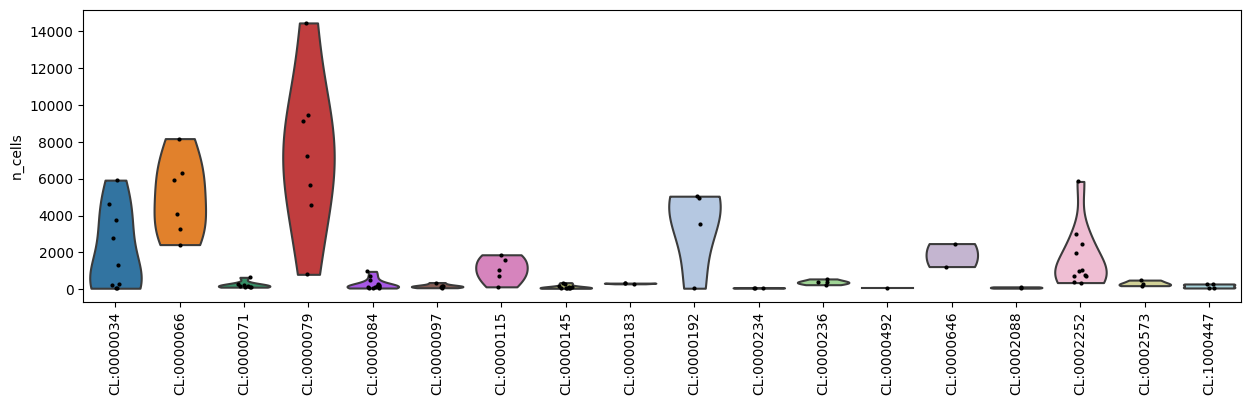

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


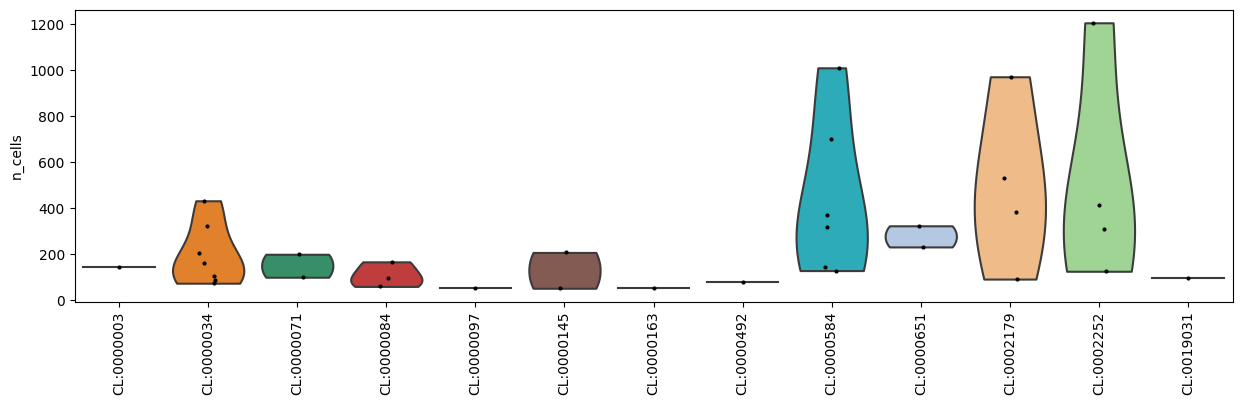

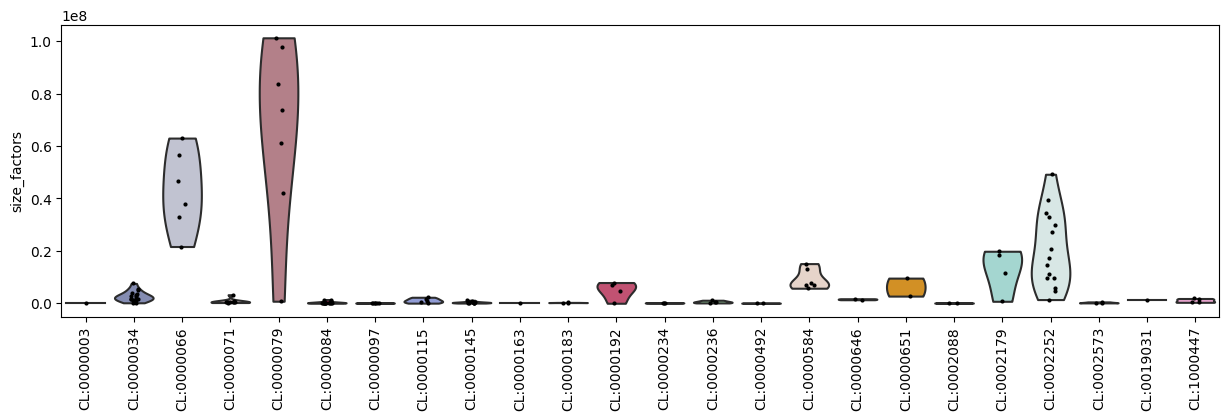

In [89]:
with plt.rc_context({'figure.figsize':[12,4]}):
    sc.pl.violin(pbulk_adata[pbulk_adata.obs['disease'] == 'normal'], 'n_cells', groupby='high_level_cell_type_ontology_term_id', rotation=90, size=3)
    sc.pl.violin(pbulk_adata[pbulk_adata.obs['disease'] != 'normal'], 'n_cells', groupby='high_level_cell_type_ontology_term_id', rotation=90, size=3)
    sc.pl.violin(pbulk_adata, 'size_factors', groupby='high_level_cell_type_ontology_term_id', rotation=90, size=3)

In [90]:
## Save pseudo-bulk data
output_dir = './data/'
pbulk_adata.write_h5ad(output_dir + f'cellxgene_targets_{disease_ontology_id}.pbulk.h5ad')

## Run DE analysis 
(by cell type)

In [116]:
import os

def run_glmGamPoi_DE(pbulk_adata, 
                     design = '~ disease',
                    ref_level = 'normal',
                    contrast = 'disease'
                    ):
    '''
    Run R code for DE analysis with glmGamPoi
    
    Params:
    ------
    - pbulk_adata: anndata object with pseudobulked data
    
    '''
    
    ## Define R function
    glmgampoi_str = f'''
        library(SingleCellExperiment)
        library(glmGamPoi)
        library(scran)
        library(scater)

        run_de <- function(args){{
            pbulk_sdata_X <- args[[1]]
            pbulk_sdata_obs <- args[[2]]
            pbulk_sdata_var <- args[[3]]

            sce <- SingleCellExperiment(assays = list(counts = t(pbulk_sdata_X)), colData = pbulk_sdata_obs)

            ## Fit
            fit <- glm_gp(sce, design = {design}, reference_level = '{ref_level}', size_factors = colData(sce)[['size_factors']])

            ## Test 
            de_res <- test_de(fit, contrast = '{contrast}')    
            de_res[,'gene_name'] <- pbulk_sdata_var['feature_name']
            return(de_res)
        }}'''
    
    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP
    
    ## Get anndata components
    pbulk_sdata_X = pbulk_adata.X.toarray().copy()
    pbulk_sdata_obs = pbulk_adata.obs.copy()
    pbulk_sdata_var = pbulk_adata.var.copy()
    
    r_pkg = STAP(glmgampoi_str, "r_pkg")
    # this was needed for the code to run on jhub
    # if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    args = [pbulk_sdata_X, pbulk_sdata_obs, pbulk_sdata_var]
    de_res_df = r_pkg.run_de(args).to_csvfile('./DE_results.csv')
    de_res_df = pd.read_csv('./DE_results.csv', index_col=0)
    de_res_df.index = de_res_df['gene_name']
    de_res_df.drop('name', 1, inplace=True)
    os.remove('./DE_results.csv')
    return(de_res_df)

In [201]:
pbulk_adata = sc.read_h5ad(output_dir + f'cellxgene_targets_{disease_ontology_id}.pbulk.h5ad')

In [202]:
n_replicates = pbulk_adata.obs.value_counts(['high_level_cell_type_ontology_term_id', 'disease']).reset_index()
ct_labels = n_replicates[n_replicates[0] >= 3]['high_level_cell_type_ontology_term_id'].unique()

In [203]:
pbulk_adata = pbulk_adata[pbulk_adata.obs['high_level_cell_type_ontology_term_id'].isin(ct_labels)].copy()

In [204]:
pbulk_adata.obs

,high_level_cell_type_ontology_term_id,assay,suspension_type,disease,donor_id,size_factors,n_cells
CL:0002252-10x 3' v2-cell-normal-Patient02,CL:0002252,10x 3' v2,cell,normal,Patient02,49214676.0,5846
CL:0000584-10x 3' v2-cell-Barrett esophagus-Patient03,CL:0000584,10x 3' v2,cell,Barrett esophagus,Patient03,13001975.0,1010
CL:0002252-10x 3' v2-cell-Barrett esophagus-Patient07,CL:0002252,10x 3' v2,cell,Barrett esophagus,Patient07,39485551.0,1206
CL:0000034-10x 3' v2-cell-normal-Patient11,CL:0000034,10x 3' v2,cell,normal,Patient11,1829870.0,1338
CL:0002252-10x 3' v2-cell-normal-Patient05,CL:0002252,10x 3' v2,cell,normal,Patient05,32838670.0,1962
...,...,...,...,...,...,...,...
CL:0000115-microwell-seq-cell-normal-Donor32,CL:0000115,microwell-seq,cell,normal,Donor32,530903.0,738
CL:0000236-microwell-seq-cell-normal-Donor32,CL:0000236,microwell-seq,cell,normal,Donor32,154331.0,385
CL:0000097-microwell-seq-cell-normal-Donor32,CL:0000097,microwell-seq,cell,normal,Donor32,79230.0,174
CL:0000145-microwell-seq-cell-normal-Donor32,CL:0000145,microwell-seq,cell,normal,Donor32,328000.0,362


### Test for cell type specificity

- Keep also the disease?

In [294]:
# Keep only normal tissue
pbulk_adata_test = pbulk_adata[pbulk_adata.obs['disease'] == 'normal'].copy()

pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'] = pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'].str.replace(":", "_").astype('category')
ct_categories = pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'].cat.categories.tolist()

celltype_de_results = pd.DataFrame()
for ct_term in pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'].unique():
    # Reorder cell type categories to include in design matrix
    ct_categories.remove(ct_term)
    ct_categories.append(ct_term)
    pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'] = pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'].cat.reorder_categories(ct_categories)

    de_results = run_glmGamPoi_DE(
        pbulk_adata_test,
        design = '~ assay + suspension_type + high_level_cell_type_ontology_term_id', # + n_cells
        ref_level = 'normal',
        contrast = f'high_level_cell_type_ontology_term_id{ct_term}'
        )
    de_results['high_level_cell_type_ontology_term_id'] = ct_term
    celltype_de_results = pd.concat([celltype_de_results, de_results], axis=0)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/tmp/ipykernel_23439/3084264888.py:60: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  de_res_df.drop('name', 1, inplace=True)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/tmp/ipykernel_23439/3084264888.py:60: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  de_res_df.drop('name', 1, inplace=True)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robject

In [205]:
celltype_de_results.sort_values('lfc')

,pval,adj_pval,f_statistic,df1,df2,lfc,gene_name,high_level_cell_type_ontology_term_id
gene_name,,,,,,,,
NLRP3,2.798355e-05,2.798355e-05,17.550104,1,inf,-52.206906,NLRP3,CL_1000447
NLRP3,2.207905e-09,2.207905e-09,35.781001,1,inf,-12.887982,NLRP3,CL_0000066
NLRP3,3.313855e-05,3.313855e-05,17.228738,1,inf,-5.410415,NLRP3,CL_0002252
NLRP3,5.951611e-01,5.951611e-01,0.282356,1,inf,0.866534,NLRP3,CL_0000079
NLRP3,1.143515e-01,1.143515e-01,2.493028,1,inf,3.056356,NLRP3,CL_0000192
NLRP3,2.521158e-02,2.521158e-02,5.009294,1,inf,3.622134,NLRP3,CL_0000236
NLRP3,4.864514e-02,4.864514e-02,3.887557,1,inf,3.819350,NLRP3,CL_0000071
NLRP3,1.346708e-02,1.346708e-02,6.106694,1,inf,4.611736,NLRP3,CL_0000115
NLRP3,7.180149e-02,7.180149e-02,3.241349,1,inf,4.725479,NLRP3,CL_0000183


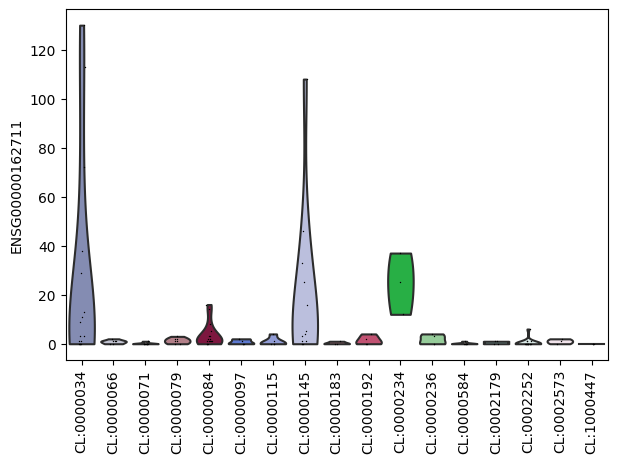

In [197]:
sc.pl.violin(pbulk_adata, pbulk_adata.var_names, groupby = 'high_level_cell_type_ontology_term_id', rotation=90)


### Test for DE disease

In [278]:
# Get clean disease label
pbulk_adata_test = pbulk_adata.copy()
pbulk_adata_test.obs['disease'] = ["_".join(x) for x in pbulk_adata_test.obs['disease'].str.split(" ")]
disease_term = pbulk_adata_test.obs['disease'][pbulk_adata_test.obs['disease'] !='normal'].unique()[0]

# pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'] = pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'].str.replace(":", "_").astype('category')
# ct_categories = pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'].cat.categories.tolist()

pbulk_adata_test.obs['disease'] = pbulk_adata_test.obs['disease'].astype('category').cat.reorder_categories(['normal', disease_term])

# Test DE between disease and healthy in cell types
disease_de_results = pd.DataFrame()
for ct_term in pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'].unique():
    ad_test = pbulk_adata_test[pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'] == ct_term].copy()
    if ad_test.obs['disease'].unique().shape[0] >= 2:
        de_results = run_glmGamPoi_DE(
            ad_test,
            design = '~ assay + suspension_type + disease',
            ref_level = 'normal',
            contrast = f'disease{disease_term}'
            )
        de_results['high_level_cell_type_ontology_term_id'] = ct_term
        disease_de_results = pd.concat([disease_de_results, de_results], axis=0)

# Test DE in "simulated bulk" - aggregating all cell types
pbulk_adata_test.obs['total_counts'] = pbulk_adata_test.obs['size_factors'].values
bulk_adata_test = anndata2pseudobulk(pbulk_adata_test, group_by=['donor_id', 'disease', 'assay', 'suspension_type'], agg='s')

bulk_de_results = run_glmGamPoi_DE(
            bulk_adata_test,
            design = '~ disease',
            ref_level = 'normal',
            contrast = f'disease{disease_term}'
            )

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/tmp/ipykernel_23439/3084264888.py:60: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  de_res_df.drop('name', 1, inplace=True)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/tmp/ipykernel_23439/3084264888.py:60: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  de_res_df.drop('name', 1, inplace=True)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robject

In [279]:
disease_de_results

,pval,adj_pval,f_statistic,df1,df2,lfc,gene_name,high_level_cell_type_ontology_term_id
gene_name,,,,,,,,
NLRP3,0.499015,0.499015,0.457030,1,inf,-3.162801e+00,NLRP3,CL:0002252
NLRP3,0.103538,0.103538,2.650188,1,inf,-1.966158e+00,NLRP3,CL:0000034
NLRP3,0.520250,0.520250,0.413397,1,inf,-1.442695e+08,NLRP3,CL:0000071
NLRP3,0.032610,0.032610,4.566154,1,inf,-2.828841e+00,NLRP3,CL:0000084
NLRP3,0.007036,0.007036,7.263770,1,inf,-7.434971e+00,NLRP3,CL:0000145
NLRP3,0.181822,0.181822,1.782668,1,inf,-1.442695e+08,NLRP3,CL:0000097


In [284]:
pbulk_adata.obs['norm_counts'] = np.log1p((pbulk_adata.X.toarray().flatten()/pbulk_adata.obs['size_factors'])*10000)
bulk_adata_test.obs['norm_counts'] = np.log1p((bulk_adata_test.X.toarray().flatten()/bulk_adata_test.obs['size_factors'])*10000)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


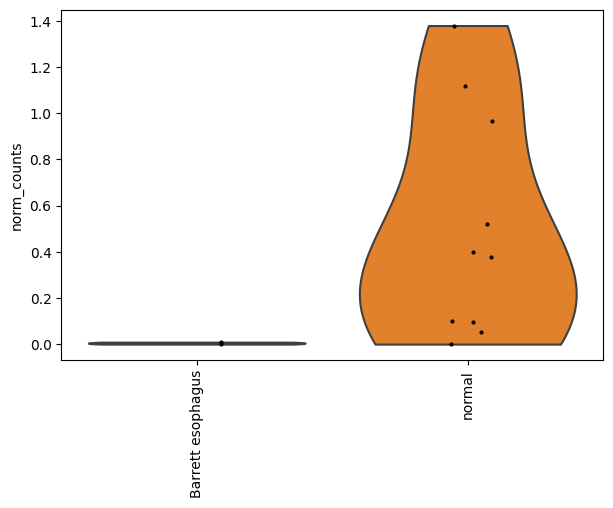

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


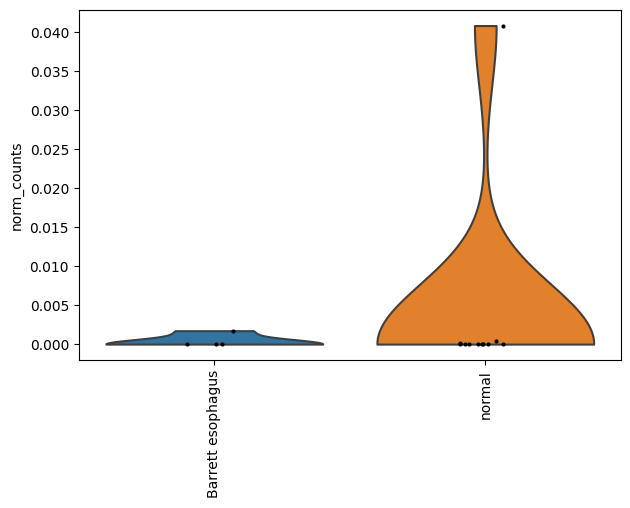

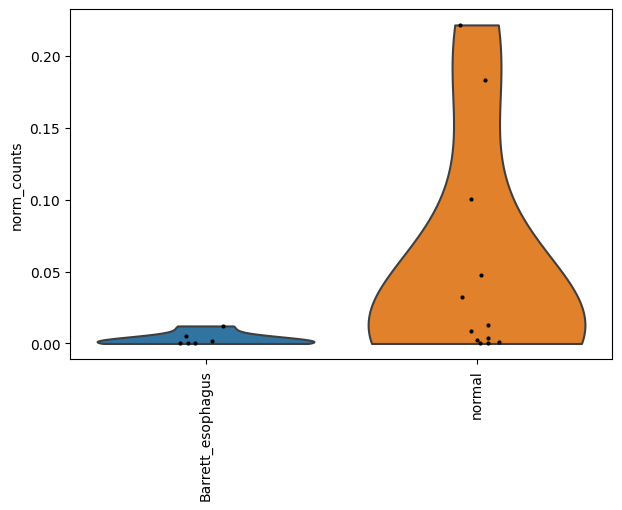

In [286]:
sc.pl.violin( pbulk_adata[ pbulk_adata.obs.high_level_cell_type_ontology_term_id == 'CL:0000145' ], 'norm_counts', groupby = 'disease', rotation=90, size=3)
sc.pl.violin( pbulk_adata[ pbulk_adata.obs.high_level_cell_type_ontology_term_id == 'CL:0002252' ], 'norm_counts', groupby = 'disease', rotation=90, size=3)
sc.pl.violin( bulk_adata_test, 'norm_counts', groupby = 'disease', rotation=90, size=3)

In [251]:
adata.obs['norm_counts'] = np.log1p((adata.X.toarray().flatten()/adata.obs['total_counts'])*10000)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


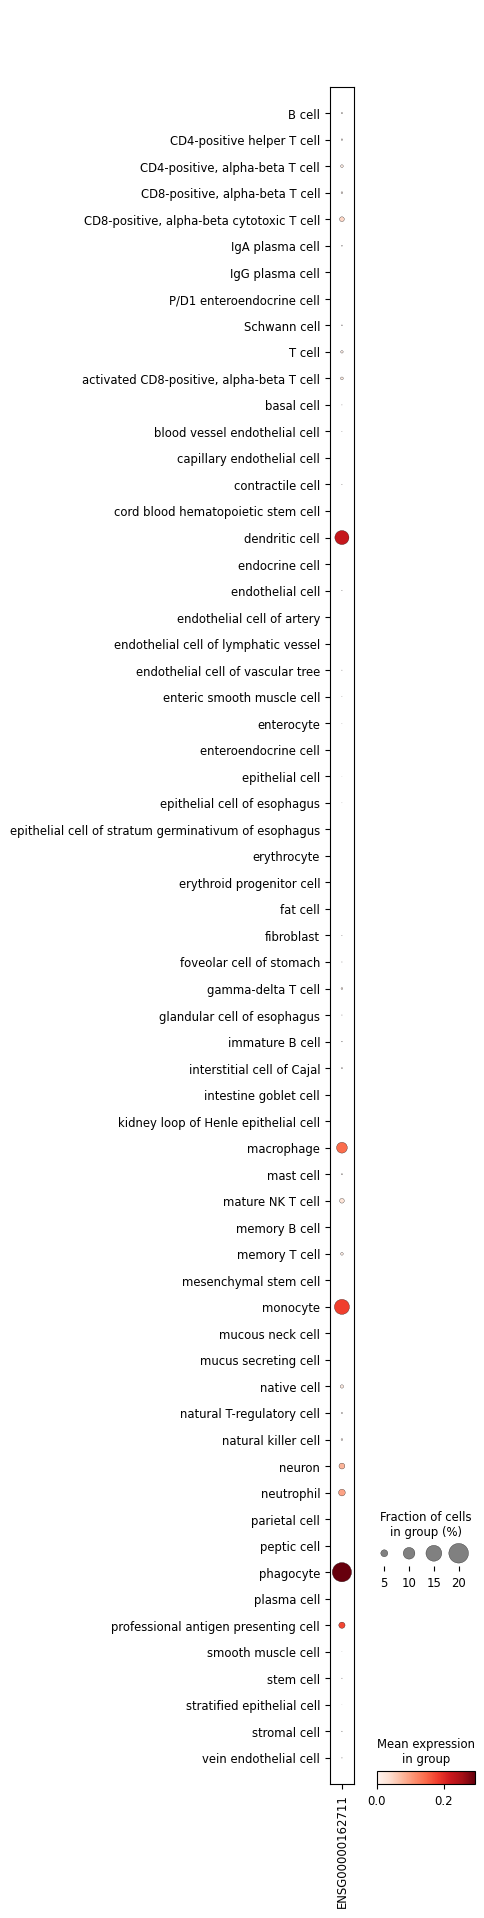

In [253]:
sc.pl.dotplot(adata, adata.var_names, groupby='cell_type')

## Transform DE results to "evidence"

In [293]:
signif_thresh = 0.01

# Are the target genes cell type markers (significantly over-expressed in a subset of cell types)
ct_specificity_evidence_targets = celltype_de_results[(celltype_de_results['pval'] < signif_thresh) & (celltype_de_results['lfc'] > 0)].gene_name.unique()

# Are the target genes differentially expressed between disease and control in a subset of cell types (and not detectable in bulk)?
disease_ct_specificity_evidence_targets = disease_de_results[(disease_de_results['pval'] < signif_thresh)].gene_name.unique()

# Make 2 classes (comparison w results you might get from bulk RNA-seq)
disease_ct_specificity_evidence_targets = disease_ct_specificity_evidence_targets[bulk_de_results.loc[disease_ct_specificity_evidence_targets]['pval'] >= signif_thresh]

## Merge with OT evidence table

In [ ]:
# ...

### Questions

- Assay: do we include all assays or just 10X?
- How to do multiple testing correction here? Across all celltypes? Across cell types and disease?
- Should the disease-specific test differentiate between celltype and disease specific as opposed to differentially expressed across cell types?
- Should the disease-specific test consider just up-regulation?